In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.0.0
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.1
pandas 1.0.0
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

4423680/4422102 [==============================] - 153s 35us/step
(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)


## 实现卷积神经网络模型

In [4]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, 
                              kernel_size=3, 
                              padding='same', 
                              activation='relu', 
                              input_shape=(28, 28, 1)))
model.add(keras.layers.Conv2D(filters=32, 
                              kernel_size=3, 
                              padding='same', 
                              activation='relu', 
                              input_shape=(28, 28, 1)))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=64,    # 在maxpooling后一般会将filters的值翻倍，以缓解maxpooling带来的参数损失 
                              kernel_size=3, 
                              padding='same', 
                              activation='relu'))
model.add(keras.layers.Conv2D(filters=64, 
                              kernel_size=3, 
                              padding='same', 
                              activation='relu', 
                              input_shape=(28, 28, 1)))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=128, 
                              kernel_size=3, 
                              padding='same', 
                              activation='relu', 
                              input_shape=(28, 28, 1)))
model.add(keras.layers.Conv2D(filters=128, 
                              kernel_size=3, 
                              padding='same', 
                              activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

In [5]:
logdir = './cnn-selu-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=10,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 184s 3ms/sample - loss: 0.7914 - accuracy: 0.7156 - val_loss: 0.4203 - val_accuracy: 0.8488
Epoch 2/10
55000/55000 [==============================] - 183s 3ms/sample - loss: 0.3953 - accuracy: 0.8566 - val_loss: 0.3876 - val_accuracy: 0.8536
Epoch 3/10
55000/55000 [==============================] - 178s 3ms/sample - loss: 0.3347 - accuracy: 0.8777 - val_loss: 0.3181 - val_accuracy: 0.8884
Epoch 4/10
55000/55000 [==============================] - 179s 3ms/sample - loss: 0.3007 - accuracy: 0.8896 - val_loss: 0.2806 - val_accuracy: 0.8992
Epoch 5/10
55000/55000 [==============================] - 180s 3ms/sample - loss: 0.2748 - accuracy: 0.8997 - val_loss: 0.2673 - val_accuracy: 0.9008
Epoch 6/10
55000/55000 [==============================] - 182s 3ms/sample - loss: 0.2543 - accuracy: 0.9067 - val_loss: 0.2557 - val_accuracy: 0.9070
Epoch 7/10
55000/55000 [===========================

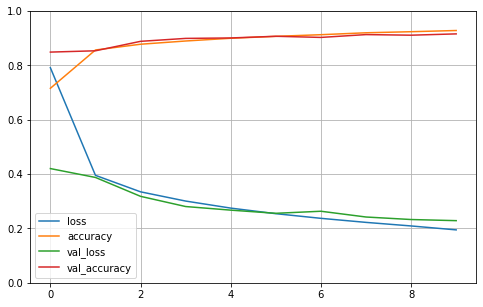

In [6]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [7]:
model.evaluate(x_test_scaled, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.2546936293005943, 0.9082]